In [ ]:
# Micheal Smoot, Zhongkun Xiang, Greg Burton
# Please use this file for grading the analysis

In [1]:
import pandas as pd
import afinn as af
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize

# Load cleaned CSVs (Polarities only included for Cali for manual classification analysis)
cali_df = pd.read_csv('California_Cleaned.csv',header = None, engine = 'python')
cali_df.columns = ['Row','Date','Text','Hashtag','Binary ID','GregPolarity','SmootPolarity','Difference']

florida_df = pd.read_csv('Florida_Cleaned.csv',header = None, engine = 'python')
florida_df.columns = ['Row','Date','Text','Hashtag','Binary ID']

# Initialize AFINN class
afinn = af.Afinn()

sent_score_florida = []
sent_score_florida_trump = []
sent_score_florida_notrump = []
isTrump = []

# Iterate through all Florida tweets and score with AFINN, separating Trump and Non-Trump tweets
for tweet_dx in range(florida_df.shape[0]):
    sent_score = afinn.score(florida_df.iloc[tweet_dx]['Text'])
    sent_score_florida.append(sent_score)
    
    if '@realdonaldtrump' in florida_df.iloc[tweet_dx]['Text']:
        sent_score_florida_trump.append(sent_score)
        isTrump.append(1)
    else:
        sent_score_florida_notrump.append(sent_score)
        isTrump.append(0)

# Normalize sentiment values
sent_score_florida = normalize(sent_score_florida)[0]
sent_score_florida_trump = normalize(sent_score_florida_trump)[0]
sent_score_florida_notrump = normalize(sent_score_florida_notrump)[0]

# Append columns to California data frame
florida_df['Sentiment'] = sent_score_florida
florida_df['isTrump'] = isTrump

sent_score_cali = []
sent_score_cali_trump = []
sent_score_cali_notrump = []
isTrump = []

# Iterate through all California tweets and score with AFINN, separating Trump and Non-Trump tweets
for tweet_dx in range(cali_df.shape[0]):
    sent_score = afinn.score(cali_df.iloc[tweet_dx]['Text'])
    sent_score_cali.append(sent_score)
    
    if '@realdonaldtrump' in cali_df.iloc[tweet_dx]['Text']:
        sent_score_cali_trump.append(sent_score)
        isTrump.append(1)
    else:
        sent_score_cali_notrump.append(sent_score)
        isTrump.append(0)

# Normalize sentiment values
sent_score_cali = normalize(sent_score_cali)[0]
sent_score_cali_trump = normalize(sent_score_cali_trump)[0]
sent_score_cali_notrump = normalize(sent_score_cali_notrump)[0]

cali_df['Sentiment'] = sent_score_cali
cali_df['isTrump'] = isTrump

#### Processes to determine Trump vs. Non-Trump scores
trump_score = 0
no_trump_score = 0

for tweet_dx in range(cali_df.shape[0]):
    if cali_df.iloc[tweet_dx]['isTrump'] == 1:
        trump_score += cali_df.iloc[tweet_dx]['Sentiment']
    else:
        no_trump_score += cali_df.iloc[tweet_dx]['Sentiment']
        
print("Cali:",trump_score,no_trump_score)

trump_score = 0
no_trump_score = 0

for tweet_dx in range(florida_df.shape[0]):
    if florida_df.iloc[tweet_dx]['isTrump'] == 1:
        trump_score += florida_df.iloc[tweet_dx]['Sentiment']
    else:
        no_trump_score += florida_df.iloc[tweet_dx]['Sentiment']
        
print("Florida:",trump_score,no_trump_score)

print(len(sent_score_florida_trump))
print(len(sent_score_cali_trump))
print(len(sent_score_florida_notrump))
print(len(sent_score_cali_notrump))

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
D:\Anaconda\lib\site-packages\skle

Cali: -2.46365272233 -7.42254345831
Florida: -2.36958593813 -6.03477282084
488
479
1817
1634


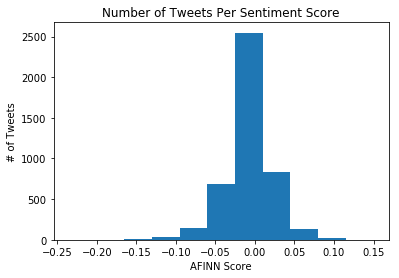

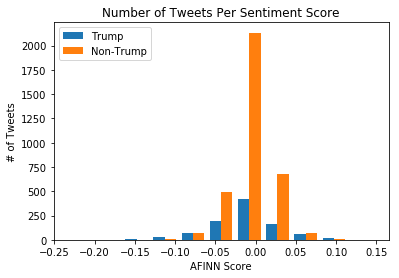

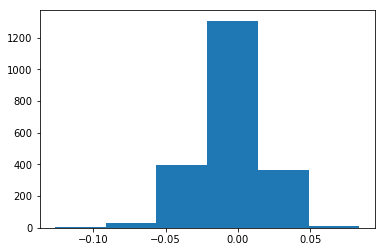

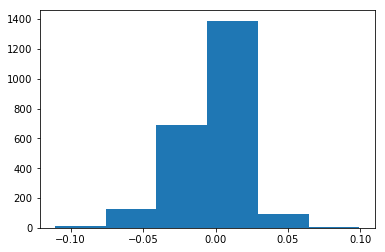

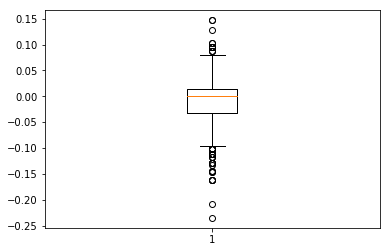

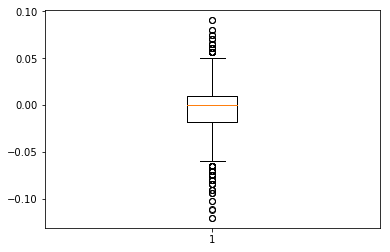

In [2]:
%matplotlib inline

# Histogram bin width
binwidth = 0.035

# Returns array of bins for histogram plots
def get_bins(data):
    return np.arange(min(data), max(data) + binwidth, binwidth)

import matplotlib.pyplot as plt

# Array of all Trump tweets
trump = []
trump.extend(sent_score_florida_trump)
trump.extend(sent_score_cali_trump)

# Array of all Non-Trump tweets
notrump = []
notrump.extend(sent_score_cali_notrump)
notrump.extend(sent_score_florida_notrump)

# ALL Tweets
plt.hist(trump+notrump,bins=get_bins(trump+notrump))
plt.title('Number of Tweets Per Sentiment Score')
plt.xlabel('AFINN Score')
plt.ylabel('# of Tweets')
plt.show()

# Trump + Non-Trump Tweets
plt.hist([trump,notrump],bins=get_bins(trump+notrump), label=['Trump','Non-Trump'])
plt.title('Number of Tweets Per Sentiment Score')
plt.xlabel('AFINN Score')
plt.ylabel('# of Tweets')
plt.legend(loc='upper left')
plt.show()

# California Only
plt.hist(sent_score_cali,bins=get_bins(sent_score_cali))
plt.show()

# Florida Only
plt.hist(sent_score_florida,bins=get_bins(sent_score_florida))
plt.show()

# Trump-related tweets
plt.boxplot(trump)
plt.show()

# Non-Trump-related tweets
plt.boxplot(notrump)
plt.show()

In [4]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score
from numpy import mean

def score(true,pred):
  return (precision_score(true,pred),recall_score(true,pred),f1_score(true,pred))

#give reason for max/min df (from analysis of data)
v = TfidfVectorizer(stop_words="english",lowercase=True, max_df=0.95,min_df=0.01)

num_labelled = 300

X = v.fit_transform(cali_df["Text"]).toarray()

y = cali_df["GregPolarity"][1:num_labelled]
X_tosplit = v.fit_transform(cali_df["Text"][1:num_labelled]).toarray()

trainX,testX,trainY,testY = train_test_split(X_tosplit,y,test_size=.20)
testY = np.ravel(testY)

### SVM ###
svm = SVC()
svm.fit(trainX,trainY)

ans = svm.predict(testX)

correct = 0

for x in range(len(ans)):
    if ans[x] == testY[x]:
        correct += 1
        
print("SVM Accuracy:",correct/len(testX))
##########

### LR ###
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(trainX,trainY)

ans = lr.predict(testX)

correct = 0

for x in range(len(ans)):
    if ans[x] == testY[x]:
        correct += 1

print("LR Accuracy:",correct/len(testX))
##########

### Linear w/ Gradient Descent ###
from sklearn import linear_model

lm = linear_model.SGDClassifier()
lm.fit(trainX,trainY)

ans = lm.predict(testX)
correct = 0

for x in range(len(ans)):
    if ans[x] == testY[x]:
        correct += 1

print("LM Accuracy:",correct/len(testX))
##########

#### Inter-rater Agreeance Score ####
y1 = cali_df["SmootPolarity"][:num_labelled]
y2 = cali_df["GregPolarity"][:num_labelled]

e = cohen_kappa_score(y1,y2)
print("Cohen-Kappa:",e)
##########

### Cross-Validation ###
lr = LogisticRegression()
cvs = cross_val_score(lr,X_tosplit,y,cv=5)
print(cvs)
##########

SVM Accuracy: 0.7833333333333333
LR Accuracy: 0.8833333333333333
LM Accuracy: 0.8166666666666667
Cohen-Kappa: 0.398574398574
[ 0.80327869  0.70491803  0.76666667  0.79661017  0.75862069]


D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


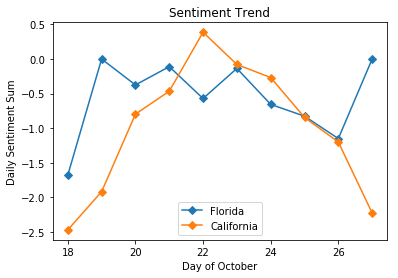

In [5]:
import datetime

# Initialize Date to first dates observes in dataset
date_itr = datetime.date(2017,10,19)

# Lists to hold aggregate sentiment values per day
sent_per_date_florida = []
sent_per_date_cali = []

# Obtain daily sentiments fpr Florida tweets
for i in range(10):
    tweets_for_date = florida_df[florida_df["Date"] == date_itr.strftime("%m/%d/%Y")]
    daterange_sent = tweets_for_date["Sentiment"]
    date_itr = date_itr + datetime.timedelta(days=1)
    sent_per_date_florida.append(sum(daterange_sent))

date_itr = datetime.date(2017,10,18)

# Obtain daily sentiments fpr California tweets
for i in range(10):
    tweets_for_date = cali_df[cali_df["Date"] == date_itr.strftime("%m/%d/%Y")]
    daterange_sent = tweets_for_date["Sentiment"]
    date_itr = date_itr + datetime.timedelta(days=1)
    sent_per_date_cali.append(sum(daterange_sent))

# Graph both sentiment lists with labels and legend info
graph = plt.plot([datetime.date(2017,10,18).day + i for i in range(10)],
         np.array([sent_per_date_florida,sent_per_date_cali]).T,
         marker='D')
plt.title('Sentiment Trend')
plt.xlabel('Day of October')
plt.ylabel('Daily Sentiment Sum')
plt.legend(['Florida','California'],loc='lower center')
plt.show()